In [ ]:
#export
#import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from fastai.distributed import *
import pandas as pd
from pathlib import Path
import time
from vidaug import augmentors as va

import torchvision.transforms as T


from modules_th.video_block import * 
from modules_th.inflator import *
from modules_th.triplet_loss import *
from modules_th.supcon_module import *
from modules_th.cus_cbs import *

#Pretrained models
from modules_th.pretrained_r2p1d50 import *
from resnetmodels.mean import get_mean_std

In [ ]:
#export
def read_data():
    prefix = '/mnt/data/eugeniomarinelli/'
    items_path = prefix + 'videodata/ucf101.csv'
    return pd.read_csv(items_path, index_col=0)

In [ ]:
df = read_data()
df = df.sample(frac=0.01)

,vid_files,lbls,val
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup,1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup,1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup,1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup,1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup,1


In [21]:
# export
def sometimes(x):
    return va.Sometimes(0.5,x)
    
def wrapVideo(x):
    return Video(x)

In [22]:
#export
def get_dsets(df, l=40, size=512,skip=20,n_views=2):
    vid_paths = df.vid_files.values
    prefix = Path('/mnt/data/eugeniomarinelli/videodata/UCF-101/')
    vid_paths = [prefix/file for file in vid_paths]
    
    
    vid_pip = [createVideoForm(l=l,skip=skip, form='img'), 
               Resize(size, method=ResizeMethod.Pad),
               sometimes(va.HorizontalFlip()),
               va.GaussianBlur(1.),
               sometimes(va.InvertColor()),
               va.RandomRotate(10),
               wrapVideo]

    lbl_pip = [parent_label, Categorize()]           
    pip = [*([vid_pip]*n_views), lbl_pip]
    #splits
    splits = ColSplitter('val')(df)

    # Datasets and dataloaders
    dsets = Datasets(vid_paths, pip, splits=splits)
    return dsets, splits
    date.today()

In [23]:
ColSplitter('val')(df)

((#98) [0,1,2,3,6,7,8,10,13,14...], (#35) [4,5,9,11,12,15,20,24,31,36...])

In [ ]:
dsets,splits = get_dsets(df)
vid = dsets[0][0]

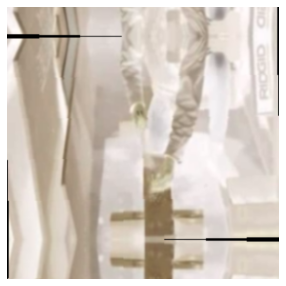

In [ ]:
vid.show()

In [ ]:
# export
def get_dls(dsets,splits,df, n_el= 2, n_lbl = 2, shuffle_fn= UniformizedShuffle, normalize='kinetics'):
        
    mean, std = get_mean_std(1,normalize)
    dls  = dsets.dataloaders(bs=n_el*n_lbl, 
                             shuffle_train=True,
                             after_item=ToTensor(),
                             after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])
    
    dls.valid.shuffle = True
    if shuffle_fn is not None:
        dls.train.shuffle_fn = UniformizedShuffle(df.lbls.iloc[splits[0]], n_el = n_el, n_lbl= n_lbl)
        dls.valid.shuffle_fn = UniformizedShuffle(df.lbls.iloc[splits[1]], n_el = n_el, n_lbl= n_lbl)
    return dls
    

In [ ]:
dls = get_dls(dsets,splits,df, normalize='kinetics')


In [ ]:
#export
def setup_log(learn,name, append=True):
     # set up logs file
    # now = datetime.now()
    # time = now.strftimes("%d_%m")
    logs_file = '/mnt/data/eugeniomarinelli/UCF_experiments/training_results/logs_ucf101_'+name+'.csv'
    Logs_csv =   CSVLogger(fname= logs_file, append=append)    
    learn.add_cb(Logs_csv)

In [ ]:
#export
def get_learner(df,
                pretrained_model='r2p1d50_K',  
                loss='CEL-SCL', 
                l=40, size=224, n_lbl =2, n_el=2, skip=20, embs_size=256,n_views=2, 
                normalize = 'kinetics'):

    dsets,splits = get_dsets(df, l, size, skip, n_views)

    dls = get_dls(dsets,splits,df, normalize=normalize)
    
    if pretrained_model in inserted_models:
        model = inserted_models[pretrained_model]
    else: raise 'model not present in pretrained models'
       
    body = create_body(model, cut=-2)
    
        


    if loss == 'SCL+CEL':
        Loss = SumLoss(SupConLoss,p='cos', alpha=1, n_views=n_views)
        body = create_body(model)
        head = inflate(create_head(256, len(dls.vocab), lin_ftrs=[]))
        model = AnomalyDetectionModel(body,head)
        metrics = [supcon_accuracy, silh_score]
        
        
    elif loss == 'SCL':
        Loss= SupConLoss() 
        head = inflate(create_head(4096, embs_size, lin_ftrs=[] ))
        model = nn.Sequential(body,head)
        metrics = [silh_score]
        
        
    elif loss == 'CEL':
        Loss = CrossEntropyLossFlat()
        head = inflate(create_head(4096, len(dls.vocab), lin_ftrs=[256]))
        model = AnomalyDetectionModel(body,head)
        metrics = [supcon_accuracy,silh_score]
        
    else :
        raise 'Loss not implemented'

    
        
    learn = Learner(dls, 
                model,
                splitter=splitter ,
                loss_func=Loss,
                metrics=metrics)

    if loss == 'CEL-SCL':
        learn.add_cbs([ContrastiveCallback(n_views)])#,LossesRecorderCallback()])
    elif loss in ['SCL', 'CEL']:
        learn.add_cb(ContrastiveCallback(n_views))
        
    setup_log(learn, str(pretrained_model)+loss+'15fr', append=True)
   
    return learn
 

In [ ]:
learn = get_learner(df, 'r2p1d50_K', loss='SCL', l=2, size=224, n_lbl =4, n_el=2, skip=20, embs_size=256,n_views=2  )
learn.add_cb(CSVLogger(fname='data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/LOGGER_PROVA' , append=False)  )

loading pretrained model /mnt/data/eugeniomarinelli/pretrained/r2p1d50_K_200ep.pth


In [ ]:
#export
def save_learner(learn, name):
    prefix = '/mnt/data/eugeniomarinelli/'
#    learn.export(prefix+'UCF_experiments/trained_models_cnn/learners/learner_ucf101_'+name)
    torch.save(learn.model,prefix+'UCF_experiments/trained_models_cnn/models/model_ucf101_'+name+'.pth')


In [ ]:
learn.cbs

In [ ]:
learn.export('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/LEARNER_CANCELLARE')
torch.save(learn.model, '/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/MODEL_CANCELLARE')

NotJSONError: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...

In [45]:
b = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/learner_ucf101_XXXXXX.pth')

In [36]:
save_learner(learn,'PROVAAA')

In [ ]:
a = load_learner('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/LEARNER_CANCELLARE')
save_learner(a,'XXXXXX.pth')

In [41]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_losses_tmp.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 05_charades.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_transformer.ipynb.
Converted 09_lr_schedule.ipynb.
Converted 10_experiments_on_images.ipynb.
Converted 11_create_embeddings.ipynb.
Converted 12_load_r2p1d_model.ipynb.
Converted CALTECH101_MixedLoss.ipynb.
Converted CALTECH101_singleloss.ipynb.
Converted UCF101.ipynb.
Converted UCF_Crimes_CEL.ipynb.
Converted UCF_Crimes_SupCon.ipynb.
Converted index.ipynb.


In [ ]:
#default_exp ucf101

Path('/mnt/data/eugeniomarinelli/videodata/UCF-101')